In [1]:
import os
import sys

sys.path.extend([
    "C:\\Users\\Wyss User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages",
    "C:\\Users\\Wyss User\\Documents\\EVs\\OLINK\\src",
])

from brainrnaseq_specificity import map_hgnc_ids, create_enrichment_dataframe, calculate_enrichment
from identify_targets import identify_targets
from raw_data_preprocessing import clean_up_raw_data, plot_protein_fractionation, ev_association_score_df

from io import StringIO

import matplotlib.pyplot as plt
import pandas as pd
import requests

os.chdir("C:\\Users\\Wyss User\\Documents\\EVs\\OLINK")

In [2]:
assay_list_path = "data\\231220_ht_panel_assay_list.xlsx"
brain_rna_seq_raw_path = "data\\240411_brain_rna_seq_raw.csv"
output_directory = "outputs\\ht_output"
plate_layout_path = "data\\231204_Walt_Olink_HT_Plate.xlsx"
raw_data = "data\\240214_Walt_Olink_HT_Raw.parquet"
uniprot_fasta_database = "data\\uniprot_fasta_database.gz"

In [3]:
# create a tidy dataframe from the raw data file

tidy_data = clean_up_raw_data(raw_data, plate_layout_path)

C:\Users\Wyss User\Documents\EVs\OLINK\src\raw_data_preprocessing.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data.loc[:, "Linear NPX"] = unique_data["PCNormalizedNPX"].map(lambda x: 2**x)


In [4]:
# identify targets found inside microglia cells that may be EV associated using the raw data file

identify_targets(
    assay_list_path = assay_list_path,
    uniprot_fasta_database = uniprot_fasta_database, 
    brain_rna_seq_raw_path = brain_rna_seq_raw_path,
    region = "internal", 
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    raw_olink_data_file = raw_data,
    plate_layout_dataframe = plate_layout_path,
    output_directory = output_directory
    )

C:\Users\Wyss User\Documents\EVs\OLINK\src\raw_data_preprocessing.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_data.loc[:, "Linear NPX"] = unique_data["PCNormalizedNPX"].map(lambda x: 2**x)


{'A2A288',
 'P14317',
 'P19838',
 'P57796',
 'Q12802',
 'Q6P0N0',
 'Q6P589',
 'Q7Z6K4',
 'Q9NP95',
 'Q9Y572'}

In [5]:
# identify targets found inside microglia cells that may be EV associated using the tidy dataframe

identify_targets(
    assay_list_path = assay_list_path,
    uniprot_fasta_database = uniprot_fasta_database, 
    brain_rna_seq_raw_path = brain_rna_seq_raw_path,
    region = "internal", 
    cell_type = "microglia", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    plate_layout_dataframe = plate_layout_path,
    tidy_dataframe = tidy_data,
    output_directory = output_directory
    )

{'A2A288',
 'P14317',
 'P19838',
 'P57796',
 'Q12802',
 'Q6P0N0',
 'Q6P589',
 'Q7Z6K4',
 'Q9NP95',
 'Q9Y572'}

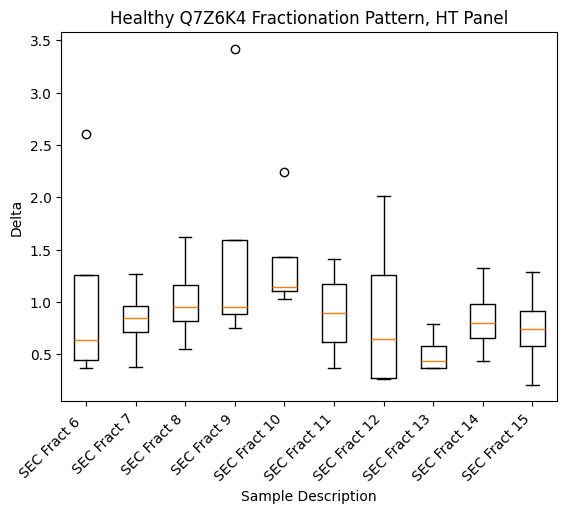

In [6]:
# make a box-and-whisker plot for a target of interest

plot_protein_fractionation(tidy_data, "Q7Z6K4")

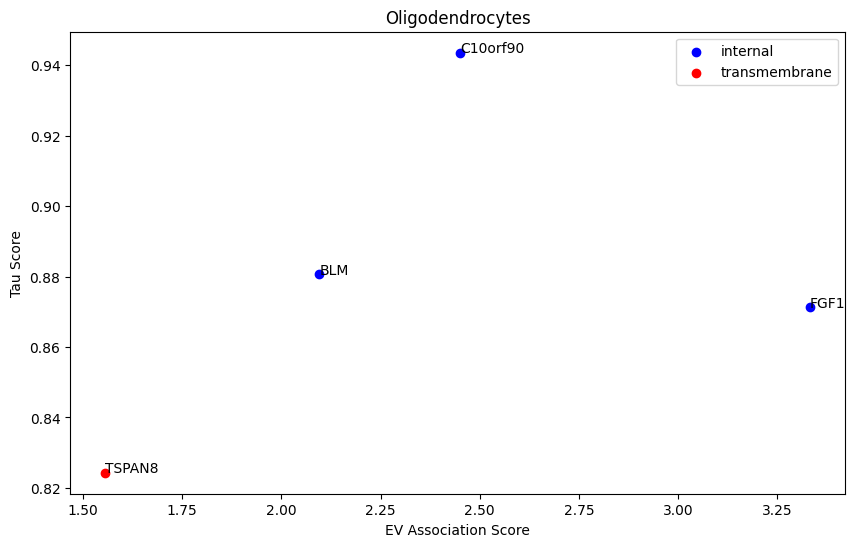

In [10]:
# Find possible oligodendrocyte-associated proteins and graph the EV association score against the tau specificity score

internal_oligodendrocyte = identify_targets(
    assay_list_path = assay_list_path,
    uniprot_fasta_database = uniprot_fasta_database, 
    brain_rna_seq_raw_path = brain_rna_seq_raw_path,
    region = "internal", 
    cell_type = "oligodendrocyte", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    plate_layout_dataframe = plate_layout_path,
    tidy_dataframe = tidy_data,
    output_directory = output_directory
    )

transmembrane_oligodendrocyte = identify_targets(
    assay_list_path = assay_list_path,
    uniprot_fasta_database = uniprot_fasta_database, 
    brain_rna_seq_raw_path = brain_rna_seq_raw_path,
    region = "TMhelix", 
    cell_type = "oligodendrocyte", 
    specificity_metric = "tau", 
    specificity_cutoff = 0.75,
    high_fractions = ['9', '10'], 
    low_fractions = ['7', '11', '12', '13'], 
    sample_health = 'healthy', 
    mean_median_individual = 'individual_median',
    plate_layout_dataframe = plate_layout_path,
    tidy_dataframe = tidy_data,
    output_directory = output_directory
    )

hgnc_ids = (
        "https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/tsv/hgnc_complete_set.txt"
    )

hgnc_uniprot_mapping_data = pd.read_csv(
    (StringIO(requests.get(hgnc_ids).text)),
    sep="\t",
    usecols=["symbol", "uniprot_ids"],
)

ev_association_scores = ev_association_score_df(tidy_data, high_fractions = ['9', '10'], low_fractions = ['7', '11', '12', '13'])
internal_oligodendrocyte_ratios_df = ev_association_scores[ev_association_scores["ht_assay"].isin(list(internal_oligodendrocyte))]
transmembrane_oligodendrocyte_ratios_df = ev_association_scores[ev_association_scores["ht_assay"].isin(list(transmembrane_oligodendrocyte))]

brain_rna_seq_data = map_hgnc_ids(brain_rna_seq_raw_path)

expression_df = create_enrichment_dataframe(brain_rna_seq_data)
tau_scores = expression_df.apply(lambda row: calculate_enrichment(row, "tau"), axis = 1)

internal_oligodendrocyte_tau = tau_scores[tau_scores.index.isin(internal_oligodendrocyte)]
transmembrane_oligodendrocyte_tau = tau_scores[tau_scores.index.isin(transmembrane_oligodendrocyte)]

internal_oligodendrocyte_df = tidy_data.loc[:, list(internal_oligodendrocyte)]
transmembrane_oligodendrocyte_df = tidy_data.loc[:, list(transmembrane_oligodendrocyte)]

internal_oligodendrocyte_tau_df = internal_oligodendrocyte_tau.reset_index()
internal_oligodendrocyte_tau_df.columns = ['uniprot_ids', 'values']
internal_oligodendrocyte_tau_df['localization'] = 'internal'

transmembrane_oligodendrocyte_tau_df = transmembrane_oligodendrocyte_tau.reset_index()
transmembrane_oligodendrocyte_tau_df.columns = ['uniprot_ids', 'values']
transmembrane_oligodendrocyte_tau_df['localization'] = 'transmembrane'

internal_oligodendrocyte_df = pd.merge(internal_oligodendrocyte_ratios_df, internal_oligodendrocyte_tau_df, left_on = "ht_assay", right_on = "uniprot_ids")
transmembrane_oligodendrocyte_df = pd.merge(transmembrane_oligodendrocyte_ratios_df, transmembrane_oligodendrocyte_tau_df, left_on = "ht_assay", right_on = "uniprot_ids")

oligodendrocyte_df = pd.concat([internal_oligodendrocyte_df, transmembrane_oligodendrocyte_df])
oligodendrocyte_df = pd.merge(oligodendrocyte_df, hgnc_uniprot_mapping_data, on = "uniprot_ids")


plt.figure(figsize=(10, 6))

for loc, group in oligodendrocyte_df.groupby('localization'):
    plt.scatter(group['ht_ratio'], group['values'], label=loc, c='blue' if loc == 'internal' else 'red')

for i in range(len(oligodendrocyte_df)):
    plt.text(oligodendrocyte_df['ht_ratio'][i], oligodendrocyte_df['values'][i], oligodendrocyte_df['symbol'][i])

plt.xlabel('EV Association Score')
plt.ylabel('Tau Score')
plt.title('Oligodendrocytes')
plt.legend()

plt.show()